# Contenidos

* [1. Comparando 2 grupos](#1.-Comparando-2-grupos)
	* [1.1 Analizando los resultados](#1.1-Analizando-los-resultados)
	* [1.2 Probability of superiority](#1.2-Probability-of-superiority)
	* [1.3 Posterior predictive check](#1.3-Posterior-predictive-check)
	* [1.4 ejercicios](#1.4-ejercicios)
* [2. Comparando más de 2 grupos](#2.-Comparando-más-de-2-grupos)
	* [2.1 "ANOVA" Bayesiano o "Banova".](#2.1-"ANOVA"-Bayesiano-o-"Banova".)
	* [2.2 ANCOVA](#2.2-ANCOVA)
* [3. Para seguir leyendo](#3.-Para-seguir-leyendo)


In [2]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_color_codes()
from plot_post import plot_post
import pandas as pd  # importar pandas

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# 1. Comparando 2 grupos

Un problema común al analizar datos consiste en comparar dos grupos de datos al hacernos preguntas como, ¿Cúan diferentes son dos grupos? ¿Podemos asegurar, razonablemente, que la diferencia es distinta de cero? ¿Cúan seguros podemos estar de que la diferencia sea tal o cual valor?. Contestar estas preguntas de apariencia trivial rápidamente se vuelve algo sutil, al darnos cuenta que no solo debemos comparar las medias si no que es necesario tener en cuenta la variabilidad de los datos y que siempre que trabajemos con datos reales hay un nivel de incerteza asociado a la medición de esos datos. Como veremos la estadística Bayesiana permite de forma simple y flexible responder a estas preguntas.

Los frecuentistas resuelven este problema mediante lo que se conoce como t-test. Basicamente hacen algunos supuestos como que los datos siguen una distribución normal y luego calculan un estimador o estadístico, resulta que este estimador sigue (bajo ciertos supuestos) una distribución t de Student (de ahí la **t** en **t**-test). 

Nosotros no vamos a hacer esto (ni entrar en detalles de como funciona este método frecuentista). Lo que haremos será usar la distribución t de Student, pero de forma diferente. Nosotros vamos a asumir que son los datos siguen una distribución t de Student con $nu$ (el parámetro que determina la _normalidad_ desconocido). Es decir si los datos así lo indican $nu$ tomará un valor alto y estaremos frente a una distribución prácticamente normal, caso contrario tendremos una curva con colas más largas/gordas que una Gaussiana. En general no será la estimación de $nu$ lo que nos interese si no las estimacioens de la media y desviación estándar de cada distribución t (una por cada grupo), que usaremos para entender si difieren y como lo hacen los 2 grupos. 

Como es una análisis Bayesiano será necesario, además especificar los _a prioris_. El modelo general que usaremos será:

<img src="imagenes/BEST.png" width=500>

Es interesante notar, que aunque a primera vista no parezca, este modelo puede ser pensado como un caso especial del modelo generalizado lineal (ver capítulo 5) cuya forma general es:

$$\mu = \alpha + \beta x$$

Solo que en nuestro caso $\alpha = 0$ y $x$ es un indicador nominal de pertenencia a un determinado grupo (control-tratamiento, vegano-omnívoro, colectivero-taxista, etc), por lo que el modelo lineal generalizado queda reducido a:

$$\mu = \beta_x$$

Vamos a suponer que por alguna razón nos interesa saber si una droga dada tiene efectos en potenciar las capacidades cognitivas en humanos. El experimento consiste en tomar un grupo de personas y realizarles una prueba de coeficiente intelectual, a la mitad de las personas se le administra la droga en cuestión (un cierto tiempo antes de realizar la prueba de coeficiente) y al resto se les da una placebo. Los datos obtenidos fueron:

In [4]:
y1 = np.array([101,100,102,104,102,97,105,105,98,101,100,123,105,103,100,95,102,106,
        109,102,82,102,100,102,102,101,102,102,103,103,97,97,103,101,97,104,
        96,103,124,101,101,100,101,101,104,100,101])# droga
y2 = np.array([99,101,100,101,102,100,97,101,104,101,102,102,100,105,88,101,100,
           104,100,100,100,101,102,103,97,101,101,100,101,99,101,100,100,
           101,100,99,101,100,102,99,100,99])  # placebo

Siempre que se pueda es buena idea visualizar los datos. Los histogramas, KDEs, boxplots y violinplots, pueden ser usados como un método cualitativo para determinar diferencias entre grupos ya que permiten rápidamente visualizar en simultaneo varias carácterísticas de las distribuciones.

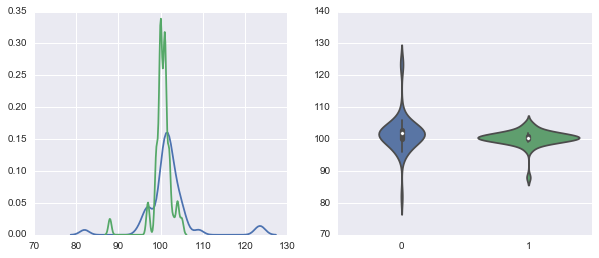

In [5]:
plt.figure(figsize=(10,4))
plt.subplot(121)
sns.kdeplot(y1)
sns.kdeplot(y2);
plt.subplot(122)
sns.violinplot(data=[y1, y2]);

En el siguiente ejemplo fijaremos _a prioris_ ligeramente informativos que pueden usarse para prácticamente cualquier problema. Como ya dijimos este tipo de _a prioris_ pueden resultar útiles al inicio del modelado de un problema, o cuando realmente no se tiene información sobre el problema, pero  si contamos con información previa entonces seguramente resultará de mucha utilidad incorporarla a nuestro análisis vía los _a prioris_.

In [6]:
with pm.Model() as modelo_best:        
    # definimos los a prioris
    grupo1_media = pm.Normal('grupo1_media', mu=np.mean(y1), sd=10)
    grupo2_media = pm.Normal('grupo2_media', mu=np.mean(y2), sd=10)
    grupo1_sd = pm.Uniform('grupo1_sd', lower=0, upper=10)
    grupo2_sd = pm.Uniform('grupo2_sd', lower=0, upper=10)
    nu0 = pm.Exponential('nu0', 1/29)
    nu = pm.Deterministic('nu', nu0+1)

    # definimos el likelihood
    grupo1 = pm.StudentT('grupo1', nu=nu, mu=grupo1_media, sd=grupo1_sd, observed=y1) # droga
    grupo2 = pm.StudentT('grupo2', nu=nu, mu=grupo2_media, sd=grupo2_sd, observed=y2) # placebo

    # variables deterministas explicadas más adelante en el texto    
    dif_medias = pm.Deterministic('dif_medias', grupo1_media - grupo2_media)
    dif_sds = pm.Deterministic('dif_sds', grupo1_sd - grupo2_sd)
    d_cohen = pm.Deterministic('d_cohen', dif_medias / 
                                   pm.sqrt((grupo1_sd**2 + grupo2_sd**2) / 2))
    
    step = pm.Metropolis()
    trace_best = pm.sample(10000, step)

Applied interval-transform to grupo1_sd and added transformed grupo1_sd_interval to model.
Applied interval-transform to grupo2_sd and added transformed grupo2_sd_interval to model.
Applied log-transform to nu0 and added transformed nu0_log to model.
 [-----------------100%-----------------] 10000 of 10000 complete in 5.9 sec

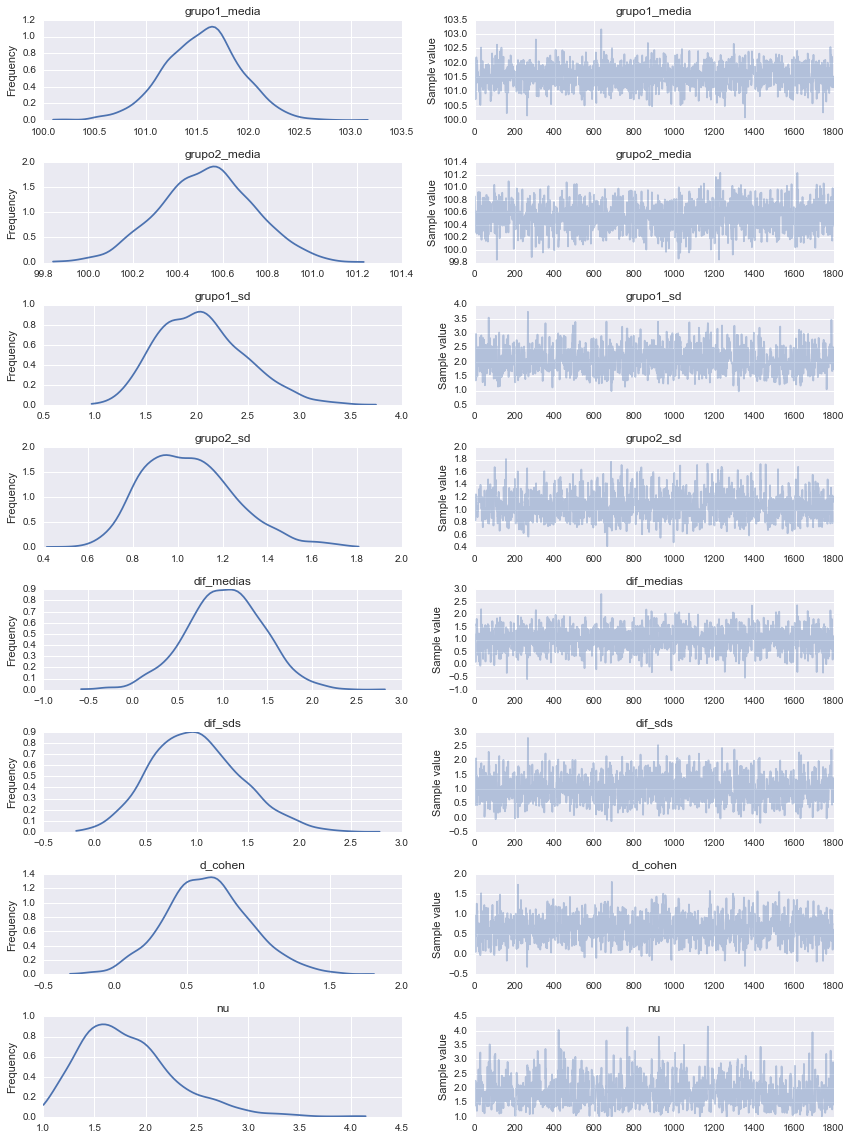

In [7]:
varnames=['grupo1_media', 'grupo2_media', 'grupo1_sd', 'grupo2_sd', 'dif_medias', 'dif_sds', 'd_cohen', 'nu']
cadena_best = trace_best[1000::5]
pm.traceplot(cadena_best, varnames);

In [8]:
pm.df_summary(cadena_best, varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
grupo1_media,101.554834,0.371315,0.009409,100.825149,102.274764
grupo2_media,100.529373,0.210870,0.005622,100.133300,100.949265
grupo1_sd,2.048009,0.424611,0.013161,1.323350,2.914550
grupo2_sd,1.051640,0.205764,0.006932,0.707709,1.483322
dif_medias,1.025461,0.431448,0.011888,0.145355,1.840992
dif_sds,0.996369,0.435269,0.011341,0.169074,1.843674
d_cohen,0.647834,0.295481,0.008456,0.095397,1.259489
nu,1.826883,0.471173,0.016660,1.039154,2.733176


In [7]:
#pm.autocorrplot(cadena, varnames);

## 1.1 Analizando los resultados

Es importante recordar que un análisis Bayesiano devuelve la distribución completa de valores creibles (dado los datos y el modelo). Muchas veces resulta conveniente convertir esta distribución continua en decisiones discretas, por ejemplo para contestar la pregunta ¿Son las medias de los grupo diferentes entre si?

En el siguiente gráfico es posible ver que el ~98% por cierto de la distribución marginal para el _a posteriori_ de las diferencias de medias está por encima de 0 y que en promedio esa diferencia está alrededor 1. Por lo tanto podemos concluir que lo más probable es que las medias no sean iguales y que es muy probable que la diferencia entre las medias sea de 1, con un HDI 95% entre ~0,1 y 1,9.

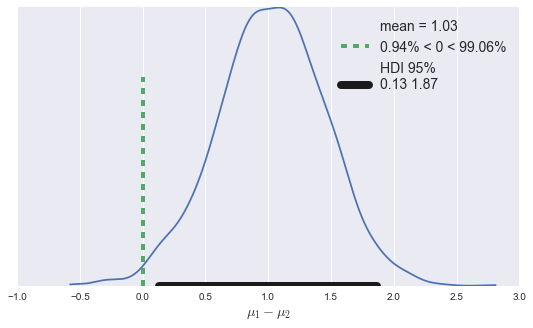

In [9]:
plt.figure(figsize=(9,5))
plot_post(cadena_best['dif_medias'], show_mode=False, xlab='$\mu_1-\mu_2$', comp_val=0);

Un análisis similar se puede hacer para las diferencias de desviaciones estándar. En el siguiente gráfico se puede ver que la desviación estándar del primer grupo (el que recibió la droga) es superior a la del grupo control. Esto, junto con la diferencia entre las medias de los grupos nos estaría diciendo que por un lado la droga es efectiva en promedio para aumentar el IQ, pero que al mismo tiempo introduce mayor dispersión entre los individuos es decir a algunos individuos los afecta negativamente mientras que a otros positivamente.

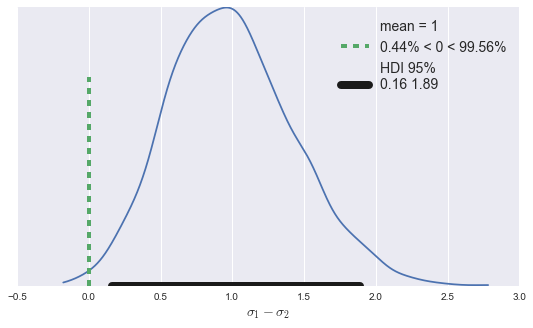

In [10]:
plt.figure(figsize=(9,5))
plot_post(cadena_best['dif_sds'], show_mode=False, xlab='$\sigma_1-\sigma_2$', comp_val=0);

### D de Cohen

Es común que estudios similares al ejemplo que acabamos de ver terminen en titulares periodísticos del estilo "Descruben droga revolucionaria que haría a la humanidad más inteligente: El fin del cambio climático, las guerras y el hambre cada vez más cerca".

A fin de tratar de evitar que esto suceda, y _a riesgo_ de que nuestro paper no salga publicado en una revista _super-top-de-mega-archi-impacto_, o incluso de encontrar que no hay nada que publicar, es necesario poner los resultados en contexto. Como vimos en el ejemplo anterior, la droga tendría un efecto sobre el coeficiente intelectual (dados nuestros datos y el modelo), pero por un lado no todos los individuos se ven igualmente beneficiados y por el otro el efecto promedio es de 1 punto de coeficiente intelectual, un valor que no es realmente alto. Una científica que trabaje con pruebas de coeficiente intelectual sabría por ejemplo que el error estándar de la media de los coeficiente intelectual se estima en 3 puntos. Es decir, la respuesta a la pregunta ¿Difieren las medias? es si, lo hacen, aunque la magnitud con que difieren podría ser considerada marginal de acuerdo al contexto en el que se realizó experimento. No puede haber análisis serio de una situación sin incorporar el contexto.

Rara vez en ciencia importa saber solo si existe o no un efecto, lo que generalmente importa es estimar el tamaño del efecto observado. Existen muchas posibles formas de medir el tamaño de un efecto (el coeficiente de correlación de Person _r_, que ya vimos, es una de ellas). Una expresión muy usada cuando se comparan medias (sobre todo por ejemplo en psicología) es usar lo que se conoce como _d de Cohen_, que se calcula como:

$$ \frac{\mu_1 - \mu_2}{\sqrt{\left(\frac{sd_1^2 + sd_2^2}{2}\right)}}$$

Es decir, el tamaño del efecto es calculado como la diferencia de las medias sobre la desviación estándar promedio. Según nuestro _a posteriori_ tenemos:

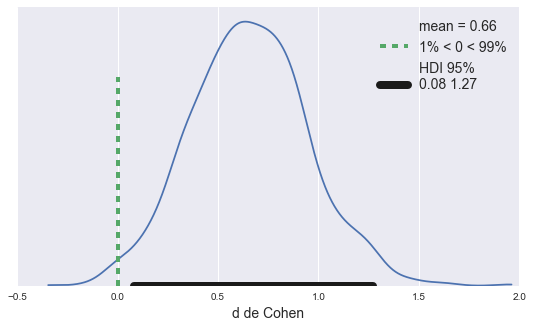

In [10]:
plt.figure(figsize=(9,5))
plot_post(cadena_best['d_cohen'], show_mode=False, xlab='d de Cohen', comp_val=0);

Introducir la variabilidad de los grupos (y no solo las medias) es importante, por que como vimos antes, un aumento o disminución que en promedio es de $x$ unidades puede ser explicado como que todos los individuos cambiaron exactamente $x$, o que la mitad cambio 0 y la otra mitad $2x$ (u otras combinaciones). Por lo tanto tener en cuenta la variabilidad de ambos grupos es crucial.  

El tamaño del efecto calculado de esta forma se puede interpretar como un _Z-score_ (asumiendo normalidad). Por ejemplo un efecto de 0.6 quiere decir que la respuesta promedio obtenida en el grupo _tratamiento_ está 0.6 desviaciones estándar por encima que la repuesta promedio en el grupo control. En [esta página](http://rpsychologist.com/d3/cohend/) encontraran un visualización interactiva que puede ser util para ayudarlos a generar intuición sobre como lucen dos distribuciones con _d de Cohen_ determinado.

Otro detalle a tener en cuenta es que, dado que nuestro cálculo es Bayesiano, el _tamaño del efecto_ es computado a partir del _a posteriori_, es decir para cada punto de la hipersuperficie del _a posteriori_ calculamos el tamaño del efecto, obteniendo la distribución de valores más probables (dado los datos y el modelo). En la literatura el _d de cohen_ se calcula usando un promedio pesado (según la cantidad de datos en cada grupo) para estimar la desviacion estándar promedio. Este promedio pesado, bajo el supuesto de igualdad de varianzas para ambas poblaciones, permite estimar con mayor precisión la varianza, que usar cualquiera de las dos varianzas. Dado que nosotros computamos el _d de cohen_ como parte de la inferencia Bayesiana (es decir a partir del _a posteriori_), no es necesario hacer correcciones según el tamaño de la muestra.

### Probabilidad de superioridad

Esta es otra forma de reportar el tamaño del efecto y se define como la probabilidad que un individuo del grupo tratamiento tenga un puntaje más favorable que uno tomado del grupo control. Puede ser calculado a partir del d de Cohen usando la siguiente formula:

$$PS = \phi(\frac{\delta}{\sqrt{2}})$$

donde $\phi$ es la función de distribución acumulada de la distribución normal estándar y $\delta$ es el _d de Cohen_. Podemos usar esta fórmula para calcular una versión puntual del $PS$ (lo que usualmente se reporta).

In [11]:
dist = stats.norm()
dist.cdf(cadena_best['d_cohen'].mean()/(2**0.5))

0.67655530831027133

Alternativamente podríamos calcular la distribución de $PS$ de acuerdo a la distribución de los _d de Cohen_ obtenidos.

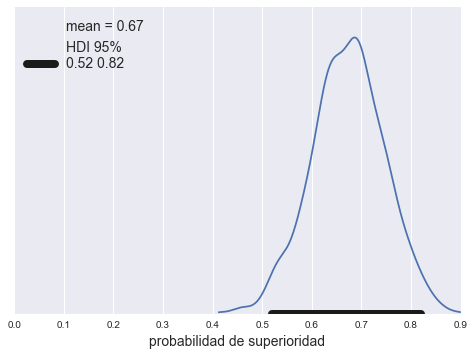

In [15]:
pd_dist = dist.cdf(cadena_best['d_cohen']/(2**0.5))
plot_post(pd_dist, xlab='probabilidad de superioridad', show_mode=False);

# 2. Comparando más de 2 grupos

Así como puede interesarnos comparar dos grupos puede que no interese comparar más de dos grupos. Vamos a ver dos formas de hacer esto:

1. Extender el modelo anterior
2. Construir un análogo Bayesiano del popular método frecuentista llamado ANOVA

Es importante aclarar que la extensión que haremos del modelo anterior, que puede pensarse como un análogo a un t-test (que es frecuentista), tiene sentido en un paradigma Bayesiano. Si en cambio estuvieramos en el paradigma frecuentista usar un t-test para comparar varios grupos sería un error, en ese caso habría que usar un ANOVA.

Para explorar estas alternativas usaremos el conjunto de datos _tips_ , incluido en _seaborn_ para demostrar sus capacidades gráficas. Nosotros lo vamos a usar para evaluar las diferencias que hay entre las propinas recibidas diferentes días de la semana en un hipotético restaurant/bar.

In [34]:
tips = sns.load_dataset("tips")
tips.tail()  # este es un comando de Pandas que permite visualizar el encabezado de un dataframe. Un dataframe es similar a un array de NumPy pero con rótulos.

,total_bill,tip,sex,smoker,day,time,size
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2
243,18.78,3.00,Female,No,Thur,Dinner,2


Del dataframe solo usaremos los datos contenidos en las columnas "day" (días) y "tips" (propinas). 

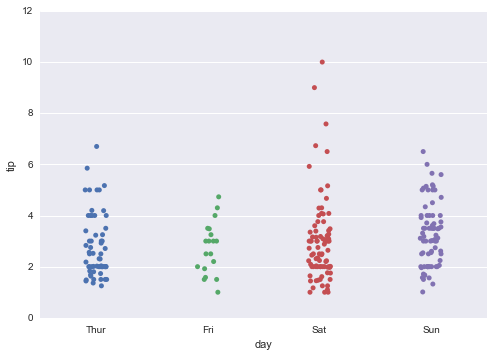

In [17]:
sns.stripplot(x="day", y="tip", data=tips, jitter=True);

A continuación crearemos un variable $y$ que contendrá los valores para las propinas y una variable $x$ que contendrá números del 0 al 3, cada uno representando los días de jueves a domingo respectivamente. 

In [21]:
y = tips['tip'].values
x = pd.Categorical(tips['day']).labels

La forma mas simple de extender el modelo es crear variables, para la media de los grupos y para la desviación estándar de los grupos cuya longitud sea igual a la cantidad de variables categóricas.

In [42]:
with pm.Model() as modelo_best_ext:        
    # definimos los a prioris
    grupos_media = pm.Normal('grupos_media', mu=0, sd=10, shape=len(set(x)))
    grupos_sd = pm.Uniform('grupos_sd', lower=0, upper=10, shape=len(set(x)))
    nu0 = pm.Exponential('nu0', 1/29)
    nu = pm.Deterministic('nu', nu0 + 1)

    # definimos el likelihood
    yl = pm.StudentT('yl', nu=nu, mu=grupos_media[x], sd=grupos_sd[x], observed=y)
    
    # muestreamos
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    #step = pm.Metropolis()
    trace_best_ext = pm.sample(5000, step, start)

Applied interval-transform to grupos_sd and added transformed grupos_sd_interval to model.
Applied log-transform to nu0 and added transformed nu0_log to model.
 [-----------------100%-----------------] 5000 of 5000 complete in 12.1 sec

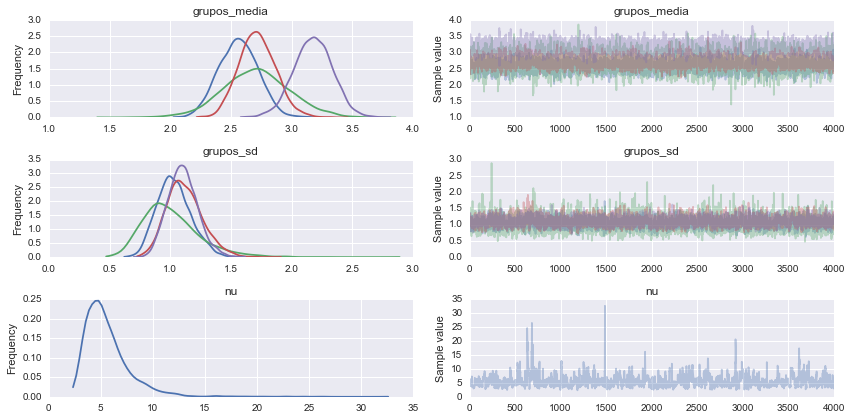

In [44]:
cadena_best_ext = trace_best_ext[1000::]
varnames = ['grupos_media', 'grupos_sd', 'nu',]
pm.traceplot(cadena_best_ext, varnames);

In [45]:
pm.df_summary(cadena_best_ext, varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
grupos_media__0,2.562162,0.160571,0.003013,2.254748,2.872756
grupos_media__1,2.709319,0.276593,0.003984,2.186290,3.287910
grupos_media__2,2.718239,0.151112,0.002877,2.422152,2.999339
grupos_media__3,3.177264,0.160151,0.002091,2.844073,3.471413
grupos_sd__0,1.031943,0.139115,0.003216,0.777996,1.313125
grupos_sd__1,1.007351,0.235444,0.004076,0.613711,1.491721
grupos_sd__2,1.118823,0.148562,0.004769,0.840513,1.415860
grupos_sd__3,1.104033,0.122305,0.002274,0.863879,1.340947
nu,5.610778,2.323016,0.109344,2.495615,9.732372


Una vez obtenidos el _a posteriori_ podemos hacer todos los análisis que creamos pertinentes, por ejemplo calcular todas las diferencias de medias _a posteriori_ entre si, junto con los valores correspondientes de la _probabilidad de superioridad_ y _d de Cohen_.

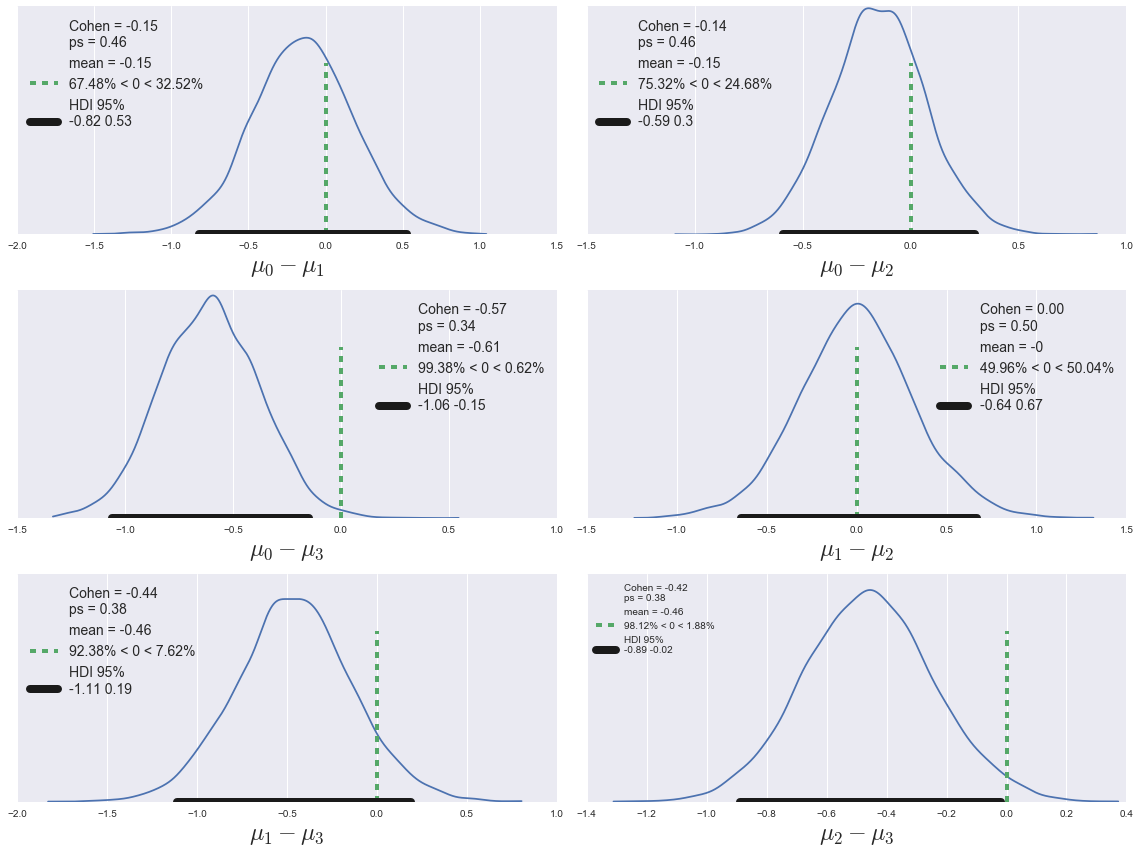

In [28]:
plt.figure(figsize=(16,12))
count = 1
for i in range(4):
    for j in range(i+1, 4):
        plt.subplot(3, 2, count)
        count += 1
        
        dif_medias = cadena_best_ext['grupos_media'][:,i]-cadena_best_ext['grupos_media'][:,j]
        d_cohen = (dif_medias / np.sqrt((cadena_best_ext['grupos_sd'][:,i]**2 + cadena_best_ext['grupos_sd'][:,j]**2) / 2)).mean()
        ps = dist.cdf(d_cohen/(2**0.5))
        
        plt.plot(0, label='Cohen = {:.2f}\nps = {:.2f}'.format(d_cohen, ps) ,alpha=0)
        plot_post(dif_medias, show_mode=False, xlab='$\mu_{}-\mu_{}$'.format(i, j), comp_val=0, fontsize=24)
plt.legend(loc=0)
plt.tight_layout()

## 2.1 "ANOVA Bayesiano o BANOVA"

En estadística frecuentista la comparación entre más de dos grupos se suele resolver recurriendo a un método llamado Análisis de la varianza o, para los amigos, ANOVA (ANalysis Of VAriance). 

Este método se basa en descomponer (analizar) la varianza en partes, por un lado la varianza dentro de cada grupo respecto de la varianza entre grupos y de ahí el nombre. Nosotros resolveremos el problema desde otra perpectiva, con un método que es similar en varios aspectos al ANOVA frecuentista, pero que no es estrictamente un ANOVA de la misma forma que resolvimos el problema de comparar dos grupos (o más) con algo parecido a un t-test, pero que no lo es.

Entre los supuestos que se hacen al realizar un ANOVA y del que depende la validez del método se destacan dos:

1. Los datos se distribuyen de forma normal.
2. Todos los grupos comparten la misma desviacion estándar (esto se conoce como homogeneidad de varianza).

En un contexto Bayesiano estos supuestos no son necesarios y podemos suponer otras cosas

El "ANOVA" Bayesiano es un modelo lineal generalizado es decir puede pensarse como un caso especial de regresión lineal:

$$\mu = \alpha + \beta X$$

Donde $\mu$ es la media de una distribucion Gaussiana. Pero como ya hemos visto, podríamos reemplazar facilmente con una distribución t de Student (y relajar el primer supuesto). 

Se diferencia de la regresión lineal en dos aspectos:

* **La variable $X$ es nomimal:** Para representar la variable nominal se usa un vector cuya longitud es igual a la cantidad de categorías también llamados _grupos_ o _tratamientos_ los (días de la semana en el _tips dataset_). Donde por ej $x_1 = [1, 0, 0, 0]$ representa la variable jueves, $x_2 = [0, 1, 0, 0]$ viernes,  $x_3 = [0, 0, 1, 0]$ sábado y  $x_4 = [0, 0, 0, 1]$ domingo. Es decir si un individuo pertenece al grupo $j$ entonces el elemento j-ésimo del vector será 1 y los demás serán ceros.

* **Cada categoría se describe como la desviación respecto de una tendencia central o linea de base**: De esta forma los coeficientes $\beta_{j} $ indican cuanto cambia el valor predicho de $y$ cuando $x$ cambia de neutro a la categoría $j$. La linea de base se restringe de forma tal que la suma de desviaciones a lo largo de los diferentes grupos sume cero.

$$\sum_j \beta_{[j]} = 0$$

0


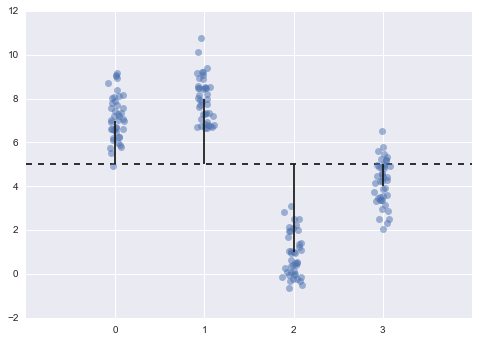

In [21]:
N_categorías = 4
alfa = 5
betas = [2, 3, -4, -1]

plt.axhline(y=alfa, color='k', ls='--')

jitter = 0.05

for i in range(N_categorías):
    datos = np.random.normal(loc=alfa+betas[i], scale=1, size=42)
    plt.plot(np.random.normal(loc=i, scale=jitter, size=len(datos)), datos, 'bo', alpha=0.5)
    plt.vlines(i, alfa, alfa+betas[i], zorder=3)
    
plt.xticks(range(N_categorías));
plt.xlim(-1, N_categorías)
print(sum(betas))

En PyMC3 resulta más simple representar la variable nominal simplemente como un índice (como ya vimos en el modelo anterior).

Una opción al hacer este análisis es usar el siguiente modelo

<img alt="regresión_lineal_simple" src="imagenes/MLG_base.png", width=300>

Este modelo, al igual que el ANOVA frecuentista, asume que $y$ se distribuye de forma normal alrededor de una valor medio para cada grupo y que las varianzas de cada uno de los grupo son totalmente independientes entre si. Por lo tanto si los _a prioris_ se hacen lo suficientemente planos, este modelo dará resultados similares a un ANOVA frecuentista. Estos dos supuestos los podemos relajar en el primer caso podríamos asumir una distribución t de student, en ves de una Gaussiana, a fin de lograr una estimacion robusta a datos alejados de esa media. En el segundo caso podriamos usar un modelo jerárquico y asumir que las varianzas de cada grupo no son totalemente diferentes sino que provienen de una distribución común. En este último caso podríamos usar el siguiente modelo:

<img alt="regresión_lineal_simple" src="imagenes/ANOVA.png", width=300>

En este modelo y siguiendo la recomendación de [Gelman](http://projecteuclid.org/euclid.ba/1340371048) hemos elegido usar una distribución de media-Cauchy como _a priori_. Esta distribución con un valor de escala relativamente alto tiene la ventaja de _permitir que los datos se expresen_ al intentar estimar el grado de contracción incluso cuando la cantidad de grupos es pequeña (menos de 5). Como siempre los resultados deberán ser analizados criticamente, si se encontrase algun problema con este _a priori_ se pueden evaluar otras alternativas como usar una distribución media-t de Student y estimar $\nu$ a partir de los datos (en vez de fijar $\nu = 1$) o usar una distribución media-normal con una varianza _alta_ (por ej 100). En caso que se prefiera un _a priori_ más informativo una distribución gamma podría resultar útil. Por supuesto también podría darse el caso en el que usar un modelo jerárquico no es buena idea por ejemplo si un experimento involucrase muchos grupos controles pero un solo tratamiento, las (posiblemente) similares varianzas entre los grupos control provocarían una contracción exagerada de la varianza del tratamiento. El uso de distribuciones con colas gordas como la Cauchy intenta disminuir este riesgo, pero podría ser que quizá convenga no usar un modelo jerárquico en lo absoluto.

In [22]:
with pm.Model() as modelo_banova:
    # definimos los hiperaprioris
    sd_h = pm.HalfCauchy('sd_h', 10)
    # definimos los a prioris
    alfa = pm.Normal('alfa', mu=0, sd=10)
    beta_tmp = pm.Normal('beta_tmp', mu=0, sd=sd_h, shape=len(set(x)))
    epsilon = pm.Uniform('epsilon', 0, 100)

    beta = pm.Deterministic('beta', beta_tmp - beta_tmp.mean())
    mu = alfa + beta[x]
    # definimos el likelihood
    yl = pm.Normal('yl', mu=mu, sd=epsilon, observed=y)
    # muestreamos
    step = pm.NUTS()
    trace_banova = pm.sample(5000, step)

Applied log-transform to sd_h and added transformed sd_h_log to model.
Applied interval-transform to epsilon and added transformed epsilon_interval to model.
 [-----------------100%-----------------] 5000 of 5000 complete in 26.6 sec

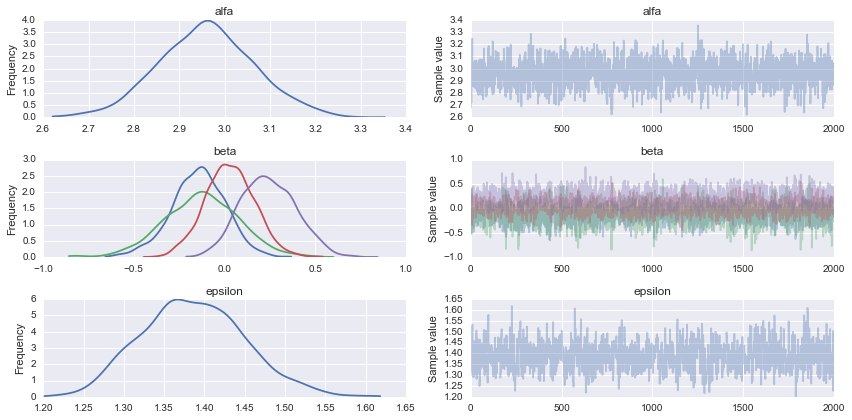

In [23]:
cadena_banova = trace_banova[1000::2]
#varnames = ['alfa', 'beta', 'epsilon', 'sd_h']
varnames = ['alfa', 'beta', 'epsilon']
pm.traceplot(cadena_banova, varnames);

In [26]:
pm.df_summary(cadena_banova, varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alfa,2.960399,0.105986,0.002557,2.747642,3.166165
beta__0,-0.143728,0.148626,0.003598,-0.465094,0.129281
beta__1,-0.126878,0.207128,0.005589,-0.538133,0.270523
beta__2,0.029045,0.135927,0.003158,-0.258497,0.279625
beta__3,0.241561,0.151276,0.004793,-0.029470,0.551161
epsilon,1.386265,0.063476,0.002213,1.269577,1.514240


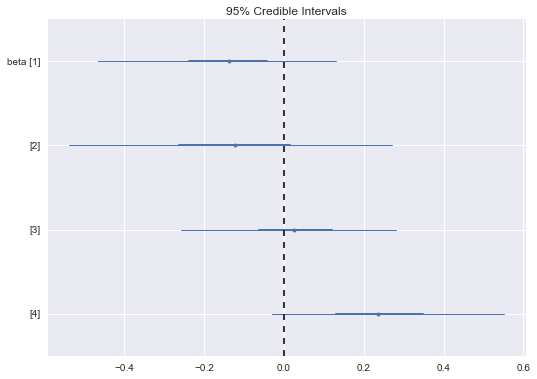

In [27]:
pm.forestplot(cadena_banova, varnames=['beta']);

## 2.2 ANCOVA

Asi como se puede hacer una regresión utilizando variables predictoras metricas y variables predictoras nominales, se puede hacer una regresión combinando ambas. Por ejemplo en el caso de las propinas podría ser que el consumo de alcohol esté vinculado a mayores propinas (la sospecha es que clientes _más felices_ dan más propina). En ese caso podríamos incluir una variable que fuese litros de cerveza o algo por el estilo. En estos casos la variable métrica se suele llamar co-variable y suele ser introducida como una variable de control. Es decir, si realmente existiese una correlación entre consumo de alcohol y generosidad de la propina al incluir la variable _consumo de alcohol_ en el modelo este permitirá estimar de mejor forma el efecto del día de la semana sobre la propina. En un contexto frecuentista este tipo de análisis recibe el nombre de ANCOVA.

# 3. Para seguir leyendo

* La publicación: [Bayesian estimation supersedes the t test. Journal of Experimental Psychology. Kruschke, John. (2012)](www.indiana.edu/~kruschke/BEST/BEST.pdf) incluye una detallada comparación entre el clásico _t-test_ y su versión Bayesiana y las razones para preferir esta última.
* Capítulos 15-16,19-20 de Doing Bayesian Data Analysis de Kruschke (2 [edición](www.amazon.com/gp/product/0124058884))

* Material online con tópicos Bayesianos:
    * [Publishable Stuff](http://sumsar.net/)
    * [Probably Overthinking It](http://allendowney.blogspot.com.ar/)
    * [Pythonic Perambulations](http://jakevdp.github.io./)
    * [While My MCMC Gently Samples](http://twiecki.github.io/)
    * [Count Bayesie](https://www.countbayesie.com/)
    * [Bayesian Methods for Hackers](http://camdavidsonpilon.github.io/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/#contents)   


* Las plantillas utilizadas para generar los diagramas de Kruschke, fueron creadas por [Rasmus Bååth's](http://sumsar.net/blog/2013/10/diy-kruschke-style-diagrams/)
* El código del t-test es una modificación del [modelo portado a PyMC3](http://pymc-devs.github.io/pymc3/BEST/) desde R por Thomas Wiecki.

In [28]:
import sys, IPython, scipy, matplotlib, platform
print("Esta notebook fue creada en una computadora %s corriendo %s y usando:\nPython %s\nIPython %s\nPyMC3 %s\nNumPy %s\nSciPy %s\nMatplotlib %s\nSeaborn %s\nPandas %s" % (platform.machine(), ' '.join(platform.linux_distribution()[:2]), sys.version[:5], IPython.__version__, pm.__version__, np.__version__, scipy.__version__, matplotlib.__version__, sns.__version__, pd.__version__))

Esta notebook fue creada en una computadora x86_64 corriendo Ubuntu 15.10 y usando:
Python 3.5.0
IPython 4.1.1
PyMC3 3.0
NumPy 1.10.4
SciPy 0.17.0
Matplotlib 1.5.1
Seaborn 0.7.0
Pandas 0.17.1
